In [1]:
# general tools
import sys
from glob import glob


# data tools
import h5py
import numpy as np
from random import shuffle
from datetime import datetime, timedelta

# deep learning tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

# graph tools
import matplotlib.pyplot as plt
%matplotlib inline

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu

In [2]:
from importlib import reload
reload(mu)

In [ ]:
sea = 'jja'

In [3]:
# import geo. info
hdf_io = h5py.File(PRISM_dir + 'PRISM_TMAX_features_2015_2020.hdf', 'r')
land_mask = hdf_io['land_mask'][...]
etopo_4km = hdf_io['etopo_4km'][...]
etopo_regrid = hdf_io['etopo_regrid'][...]
lon_4km = hdf_io['lon_4km'][...]
lat_4km = hdf_io['lat_4km'][...]
hdf_io.close()

grid_shape = land_mask.shape

# defining prediction range
# dt list for all
N_all = 365 + 366 + 365 + 365 + 365
all_list = [datetime(2015, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# dt list for pred, 2018-2019
# N_pred = 365
# pred_list = [datetime(2019, 1, 1, 0) + timedelta(days=x) for x in range(N_pred)]

N_pred = 15
pred_list = [datetime(2019, 7, 1, 0) + timedelta(days=x) for x in range(N_pred)]

# indices
ind_pred = du.dt_match(all_list, pred_list)

In [4]:
with h5py.File(PRISM_dir + 'PRISM_TMEAN_features_2015_2020.hdf', 'r') as hdf_io:
        PRISM_T = hdf_io['TMEAN_4km'][ind_pred, ...]
        REGRID_T = hdf_io['TMEAN_REGRID'][ind_pred, ...]

# Testing on batches

In [5]:
cmap_mae = plt.cm.plasma_r
camp_t2 = gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r)

In [6]:
input_flag = [False, True, False, False, True, True] # LR T2, HR elev, LR elev
output_flag = [True, False, False, False, False, False] # HR T2
inout_flag = [True, True, False, False, True, True]
labels = ['batch', 'batch'] # input and output labels

In [7]:
file_path = BATCH_dir
model_import_dir = temp_dir

In [8]:
G_base = keras.models.load_model(model_import_dir+'UNET-G3_TMEAN_jja_tune.hdf')
opt_G = keras.optimizers.Adam(lr=0)

G_base.compile(loss=keras.losses.mean_squared_error, optimizer=opt_G)

In [9]:
G_style = keras.models.load_model(model_import_dir+'STRANS_G_TMEAN_jja.hdf')
opt_G = keras.optimizers.Adam(lr=0)

G_style.compile(loss=keras.losses.mean_squared_error, optimizer=opt_G)

In [10]:
file_path = BATCH_dir
trainfiles = glob(file_path+'TMEAN_BATCH_96_TORI_*{}*.npy'.format(sea))
validfiles1 = glob(file_path+'TMEAN_BATCH_96_TSUB_*{}*.npy'.format(sea)) + glob(file_path+'TMEAN_BATCH_96_VSUB_*{}*.npy'.format(sea))
validfiles2 = glob(file_path+'TMEAN_BATCH_96_VORI_*{}*.npy'.format(sea))
#
L_train = len(trainfiles)
gen_valid_base1 = tu.grid_grid_gen(validfiles1, labels, input_flag, output_flag)
gen_valid_base2 = tu.grid_grid_gen(validfiles2, labels, input_flag, output_flag)

gen_valid_style1 = tu.grid_grid_gen_noise(validfiles1, labels, input_flag, output_flag, 384)
gen_valid_style2 = tu.grid_grid_gen_noise(validfiles2, labels, input_flag, output_flag, 384)

In [11]:
G_base.evaluate_generator(gen_valid_base1, verbose=1)
G_style.evaluate_generator(gen_valid_style1, verbose=1)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node StatefulPartitionedCall/conv2d/Conv2D}}]] [Op:__inference_restored_function_body_19538]

Function call stack:
restored_function_body


In [11]:
G_style.evaluate_generator(gen_valid2, verbose=1)

113/113 [==============================] - 29s 255ms/step - loss: 0.0213


0.021286129226199293

In [36]:
validfiles = glob(file_path+'TMEAN_BATCH_96_VSUB_*{}*.npy'.format(sea))

In [37]:
temp_data = np.load(validfiles[0], allow_pickle=True)[()]
X = temp_data['batch']
Y = X[..., output_flag]

In [38]:
latent_size = 96
samples = 500
GEN = np.zeros([samples, 200, 96, 96])

for i in range(samples):
    Wf = np.random.normal(0.0, 1.0, size=[batch_size, latent_size])
    #Wf = np.ones([batch_size, latent_size])
    IN = [Wf, X[..., input_flag]]

    P = G_style.predict(IN)
    GEN[i, ...] = P[..., 0]

In [39]:
ind = 1

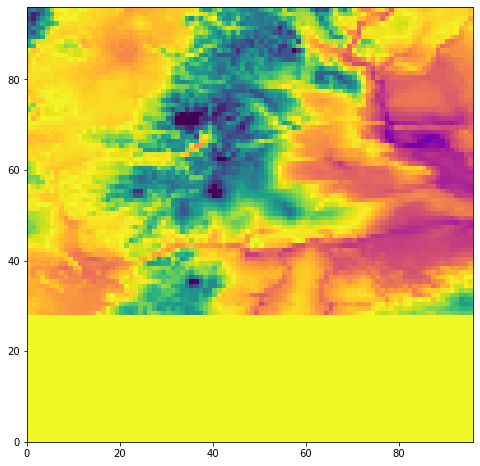

In [52]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(Y[ind, ..., 0], vmin=-3, vmax=3, cmap=camp_t2)

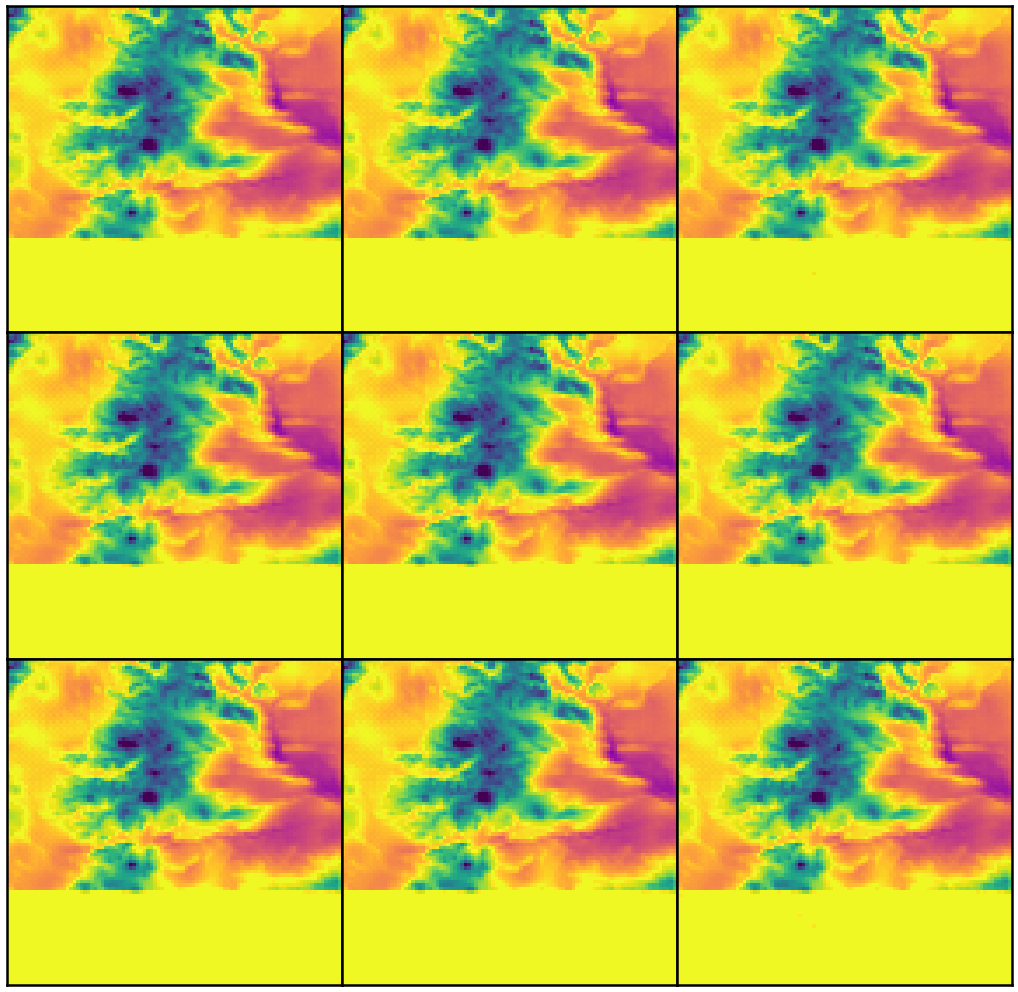

In [41]:
fig, AX = plt.subplots(3, 3, figsize=(18, 18))
plt.subplots_adjust(wspace=0, hspace=0)
AX = AX.ravel()

for i, ax in enumerate(AX):
    ax = gu.ax_decorate_box(ax)
    ax.pcolormesh(GEN[i, ind, ...], vmin=-3, vmax=3, cmap=camp_t2)

In [42]:
STD = np.std(GEN, axis=0)

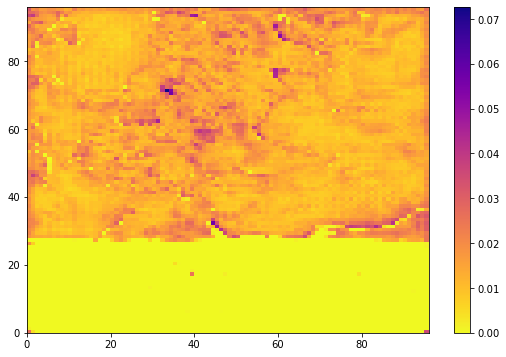

In [43]:
plt.figure(figsize=(9, 6))
plt.pcolormesh(STD[ind, ...], cmap=cmap_mae)
plt.colorbar()

(array([  2.,   5.,  29.,  93., 133., 130.,  74.,  27.,   4.,   3.]),
 array([-0.5854761 , -0.57880202, -0.57212794, -0.56545386, -0.55877978,
        -0.5521057 , -0.54543161, -0.53875753, -0.53208345, -0.52540937,
        -0.51873529]),
 <a list of 10 Patch objects>)

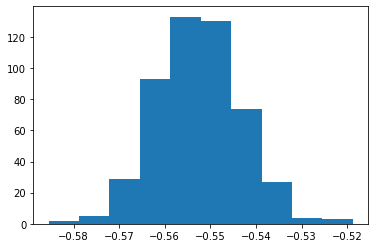

In [44]:
plt.hist(GEN[:, ind, 50, 50])

(array([  4.,  10.,  28.,  73.,  88., 107.,  97.,  58.,  28.,   7.]),
 array([0.48994392, 0.49541392, 0.50088392, 0.50635393, 0.51182393,
        0.51729393, 0.52276393, 0.52823393, 0.53370394, 0.53917394,
        0.54464394]),
 <a list of 10 Patch objects>)

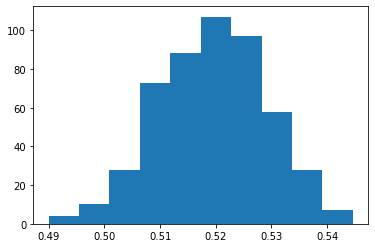

In [45]:
plt.hist(GEN[:, ind, 72, 67])

In [47]:
grid_shape = GEN.shape

In [50]:
p99 = np.zeros([96, 96])

for i in range(96):
    for j in range(96):
        temp_series = GEN[:, ind, i, j]
        temp_mean = np.mean(temp_series)
        if temp_mean < -0.1:
            p99[i, j] = np.min(temp_series)
        elif temp_mean > 0.1:
            p99[i, j] = np.max(temp_series)
        else:
            p99[i, j] = temp_mean

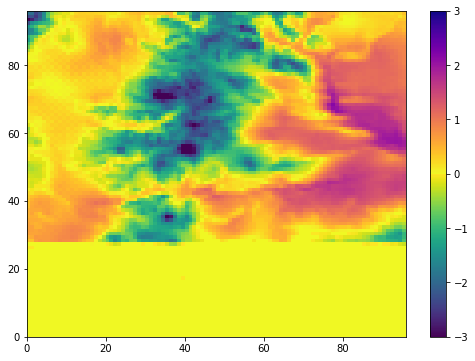

In [51]:
plt.figure(figsize=(8.5, 6))
plt.pcolormesh(np.mean(GEN[:, ind, ...], axis=0), vmin=-3, vmax=3, cmap=camp_t2)
plt.colorbar()

In [79]:
np.percentile(temp_series, 0.001)

0.5141119352364539

In [76]:
temp_data = np.load(glob(BATCH_dir+'ETOPO*96*.npy')[3], allow_pickle=True)[()]

In [78]:
# for i in range(200):
#     plt.figure(figsize=(6, 6))
#     plt.pcolormesh(temp_data['batch'][i, ..., 1], vmin=-3, vmax=3, cmap=camp_t2)